# Principal components analysis for order parameter construction

In [1]:
from analysis_tools.read_gsd import ReadGSD
from analysis_tools.feature_creation import FrameToFeatures, TrajectoryToFeatures, TrajectoryToFeaturesBatch, TrajectoryToFeaturesBatchR
from analysis_tools.feature_creation import FrameToFeaturesComposition, TrajectoryToFeaturesComposition
from IPython.display import clear_output

---

## Models

In [2]:
from numpy import array, arange, floor, floor

### Model data

#### Hard disks

In [3]:
###Kappa=6
particle_inc = 100 #skip this many particles in generating features; #wp: because it selects index 0 be default, rounds up to integer if not a mulptiple of Ntot
N_nn = 3000 #number of nearest nighbors for pca analysis #wp:Should not be bigger than Ntotal
nn_inc = 10 #reduces the number of nearest neighbors to include as features
split = 2 #chunks the data up so it can be processed by the pca tool if really large
N_batch=1
frame_skip=4

#method = ['distance']
method = ['orientation']

In [4]:
#specify what data to read in and process
#wp:there are 51 eta points given range below
folder='ellipsoids/kappa_6.0_3N'; 
#file_data = [(arange(0.4600, 0.9000, 0.01), folder)] 
file_data = [(arange(0.4600, 0.5600, 0.01), folder),
             (arange(0.5650, 0.5950, 0.005), folder),
             (arange(0.6000, 0.9001, 0.01), folder)             
            ]

### Density range

In [5]:
#wp: the `_' variable is a dummy return variable like `~' in matlab
#wp: Here, the for loop returns two arguments but only keeps the first that contains all the numbers
etas = []
[etas.extend(etas_) for etas_, _ in file_data]
etas = array(etas)
#print(etas)

---

## Perfom PCA

In [6]:
from numpy import array_split
from sklearn.decomposition import IncrementalPCA

### Train on ideal gas structure first to identify trivial variance contributions

In [7]:
#n_components_ig = N_nn/nn_inc-1  #for this the more the better, however, 50 is probably enough
n_components_ig = N_batch*N_nn/nn_inc  #for this the more the better, however, 50 is probably enough
#n_components_ig = N_nn/nn_inc*(N_batch+2) #for this the more the better, however, 50 is probably enough
#print n_components_ig

In [10]:
from analysis_tools.feature_creation import FrameToFeatures, TrajectoryToFeatures

###wp: Ideal gas pca structure
incpca_ig = IncrementalPCA(n_components=n_components_ig, whiten=True)  #NOTICE: whitening is on here

frames = None
features = None
split_features = None
#split=1

#features_partial_ig=[];

for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True, randomize=True)        
        #print frames[0]['orientation'][0:5]
        
        frames_split = array_split(frames, split)
        
        #frames = None
        count = 0
        
        for frames_partial in frames_split:
        #for frames_partial in frames_split[0:-1:2]:
            #features_partial = TrajectoryToFeatures(frames_partial, N_nn=N_nn, method=method, 
            #                                        particle_inc=particle_inc, nn_inc=nn_inc)
            #wp: Rather than using all frames by default, allow setting to skip some
            
            #if eta > 0.8200:
            #    N_nni=N_nn2; particle_inci=particle_inc2; nn_inci=nn_inc2;
            #else:
            N_nni=N_nn; particle_inci=particle_inc; nn_inci=nn_inc;
                
            frames_partial=frames_partial[::frame_skip]
        
            features_partial = TrajectoryToFeaturesBatch(frames_partial, N_nn=N_nni, method=method, 
                                                         particle_inc=particle_inci, nn_inc=nn_inci,N_batch=N_batch)
            
            #features_partial = TrajectoryToFeaturesBatchR(frames_partial, N_nn=N_nni, method=method, 
             #                                            particle_inc=particle_inci, nn_inc=nn_inci,N_batch=N_batch)


            
            print features_partial.shape
            incpca_ig.partial_fit(features_partial)
            count = count + 1
            print count
            
        clear_output()
        frames_split = None
        #features_partial_ig.append(features_partial)
        

### Train on actual data with trivial data variance removed by the ideal gas model

In [8]:
#n_components = N_nn/nn_inc-1 #this number will not affect the quality of the result just the computation time and amount of info returned
n_components = N_batch*N_nn/nn_inc  #for this the more the better, however, 50 is probably enough
#n_components = 2*N_nn/nn_inc  #for this the more the better, however, 50 is probably enough
#n_components = N_nn/nn_inc*(N_batch+2) #for this the more the better, however, 50 is probably enough

In [12]:
incpca = IncrementalPCA(n_components=n_components , whiten=False)  #NOTE: not whitening here

frames = None
features = None
split_features = None
#split=1
features_partial_ellipse=[]

for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True, randomize=False)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            #features_partial = TrajectoryToFeatures(frames_partial, 
            #                                        N_nn=N_nn, 
            #                                        method=method, 
            #                                        particle_inc=particle_inc, 
            #                                        nn_inc=nn_inc)
            

            #if eta > 0.8200:
            #    N_nni=N_nn2; particle_inci=particle_inc2; nn_inci=nn_inc2;
            #else:
            N_nni=N_nn; particle_inci=particle_inc; nn_inci=nn_inc;
                
            frames_partial=frames_partial[::frame_skip]
               
            features_partial = TrajectoryToFeaturesBatch(frames_partial, N_nn=N_nni, method=method, 
                                                         particle_inc=particle_inci, nn_inc=nn_inci,N_batch=N_batch)
            
            #wp:project *hard disk* features onto ig eigenvectors
            incpca.partial_fit(incpca_ig.transform(features_partial))
            #count = count + 1
            #print count
        clear_output()
        frames_split = None
        #features_partial_ellipse.append(features_partial)

### System train without ideal gas correction

In [30]:
########wp: System fit *without ideal gas*
incpca = IncrementalPCA(n_components=n_components , whiten=False)

frames = None
features = None
split_features = None

split=1
for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True, randomize=False)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            #features_partial = TrajectoryToFeatures(frames_partial, 
            #                                        N_nn=N_nn, 
            #                                        method=method, 
            #                                        particle_inc=particle_inc, 
            #                                        nn_inc=nn_inc)
            
            frames_partial=frames_partial[::frame_skip]
            features_partial = TrajectoryToFeaturesBatchR(frames_partial, 
                                                    N_nn=N_nn, 
                                                   method=method, 
                                                    particle_inc=particle_inc, 
                                                    nn_inc=nn_inc,N_batch=N_batch)
            
            #wp: fits pure system features (no idea gas reduction)
            incpca.partial_fit(features_partial)
            count = count + 1
            print "Frame split: ", count
        #wp:resets frame split
        clear_output()
        frames_split = None

# Fitting of models and analysis

### Saves trained model to avoid retraining every time as well as memory issues

In [13]:
from sklearn.externals import joblib
folder_model='trained_models'
model_ig=folder_model+'/kappa_6.0_ig.pca'; model=folder_model+'/kappa_6.0.pca';
#wp: Saves model as file
#ideal gas trained model
joblib.dump(incpca_ig,model_ig)
#full trained model
joblib.dump(incpca,model)

['trained_models/kappa_6.0.pca']

### Loads saved models

In [9]:
from sklearn.externals import joblib
#paths to where models are located
folder_model='trained_models'
model_ig=folder_model+'/kappa_6.0_ig.pca'; 
model=folder_model+'/kappa_6.0.pca';

incpca_ig=joblib.load(model_ig);
incpca=joblib.load(model);

### Compute the order parameters based on two nested models

In [10]:
frames = None
features = None
raw_OPs = []
#split=1

for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        #wp: randomize undefined here?
        frames = ReadGSD(filename, shuffle_data=True, randomize=False)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        means = []
        raw_OPs_single = []
        for frames_partial in frames_split:
            #features_partial = TrajectoryToFeatures(frames_partial, 
            #                                        N_nn=N_nn, 
            #                                        method=method, 
            #                                        particle_inc=particle_inc,            
            #                                       nn_inc=nn_inc)
            
            N_nni=N_nn; particle_inci=particle_inc; nn_inci=nn_inc;
                
            frames_partial=frames_partial[::frame_skip]
            #frames_partial=frames_partial[0:50]
        
            features_partial = TrajectoryToFeaturesBatch(frames_partial, N_nn=N_nni, method=method, 
                                                         particle_inc=particle_inci, nn_inc=nn_inci,N_batch=N_batch)
            
            #wp: This returns the 'Z=X*U' matrix with mxn dimensions, where m=samples and n=feature vectors
            transformed_features_partial = incpca.transform(incpca_ig.transform(features_partial))
            #transformed_features_partial = incpca_ig.transform(features_partial)
            #wp:No ideal gas correction
            #transformed_features_partial = incpca.transform(features_partial)
            raw_OPs_single.append(transformed_features_partial)
            #count = count + 1
            #print count
        clear_output()
        raw_OPs.append(raw_OPs_single)  

### Compute order parameter stats

In [11]:
from numpy import array, mean, std, abs, asarray

In [12]:
OPs = []
OPs_std = []
OPs_abs = []

for single_eta in raw_OPs:
    merged_data = []
    
    #wp: here single_eta is just the feature vector of samples; the for loop below extracts it as array 'split'
    for split_eta in single_eta:
        merged_data.extend(split_eta)

    #wp: averages over all samples m
    OPs.append(mean((split_eta), axis=0))
    OPs_std.append(std(split_eta, axis=0))
    OPs_abs.append(mean(abs(split_eta), axis=0))

OPs = array(OPs)
OPs_std = array(OPs_std)
OPs_abs = array(OPs_abs)

In [13]:
#wp:figuring things out...
print "The feature matrix input for each eta is of dimensions",len(features_partial),len(features_partial[0])

eta_index=0
print "Number of rows: ", len(raw_OPs)
print "Array size for each eta: ", raw_OPs[eta_index][0].shape
print raw_OPs[eta_index][0][0]

raw_OP_sample=[]
raw_OP_samples=[]
samplenum=20
for mi in range(samplenum):
    for eta_index in range(len(raw_OPs)):
        raw_OP_sample.append(raw_OPs[eta_index][0][mi][0])
    raw_OP_samples.append(asarray(raw_OP_sample))
    raw_OP_sample=[]

#wp: for the averaged value
print "Shape of average order parameter", OPs.shape

for i in range(len(raw_OP_samples)):
    plt.plot(etas,raw_OP_samples[i], 'o-')

The feature matrix input for each eta is of dimensions 15000 300
Number of rows:  49
Array size for each eta:  (15000, 300)
[-12.80131123   1.79004021  -0.90203643   1.64709942  -1.03173597
   0.58441785   0.32979468   0.95960179  -0.0252967   -0.40452592
   0.85227722   0.02499755   0.83308772   0.43748513   0.17451508
  -1.77619915   0.23251358  -1.81038242   0.40845635   0.01417756
   1.51857249  -0.35313561   0.81955166  -0.23686775  -2.56693751
  -0.38621321  -0.36115671   1.95044519  -0.11451782   0.0213907
  -1.29780171   0.15523541  -0.07347703  -1.24899401  -0.07482976
  -0.46536573   1.25980158  -1.09548178  -0.50775375  -0.30392873
  -0.3027295   -1.49420139  -1.20078198  -1.64181315   0.70877878
   0.11904293  -1.45501507   0.21035072   1.32634135  -1.24284462
   1.06402874  -0.25972424   0.35155214   0.28923806   0.36813365
   1.74139517   1.48083557  -1.09952718   1.05056086  -0.4963036
   1.63538774  -0.51433718  -0.18266404  -0.06778668  -0.85083073
   0.68818466   2.20

NameError: name 'plt' is not defined

---

## Check out the results of PCA

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint

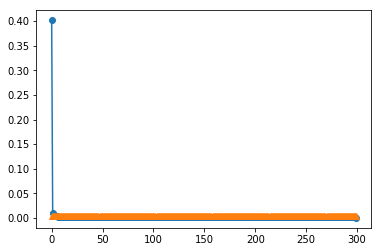

In [15]:
####wp: Comparing the component variance for the hard disk and ideal gas system
import matplotlib.pyplot as plt
import numpy as np

plt.plot(incpca.explained_variance_ratio_,marker='o')
plt.plot(incpca_ig.explained_variance_ratio_,marker='^')

#plt.ylim(-0.1,0.1)


### Explained variance

/home/pineros/programs/local/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family [u'arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


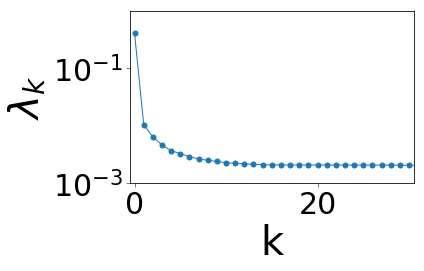

In [16]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

#plt.plot(incpca.explained_variance_ratio_, marker='o', linewidth=1.0, markersize=12, color = 'red', markerfacecolor='None') 
plt.plot(incpca.explained_variance_ratio_, marker='o', linewidth=1.0, markersize=5) 


#backround grid details
axes = plt.gca()
#axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
#axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [12,12]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.yscale('log')
plt.xlim([-0.5,30.5]); plt.ylim([1e-3,1])

#plt.yscale('log')
#!!!wp: Why eta? #Shouldn't be features?
plt.xlabel(r'k', y=3, fontsize=40, fontdict = axis_label_font)
plt.ylabel(r'$\lambda_k$', fontsize=40, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=30)
plt.tight_layout()
#plt.title('Explained variance for principal components', y=1.05, fontdict = title_font)

#saves
#plt.savefig('figures/OP_variance_orientation_4_3N.svg')
plt.show()

### Principal component weights

In [17]:
from numpy import dot
components = dot(incpca.components_, incpca_ig.components_)
components_ig = incpca_ig.components_
#components = incpca.components_

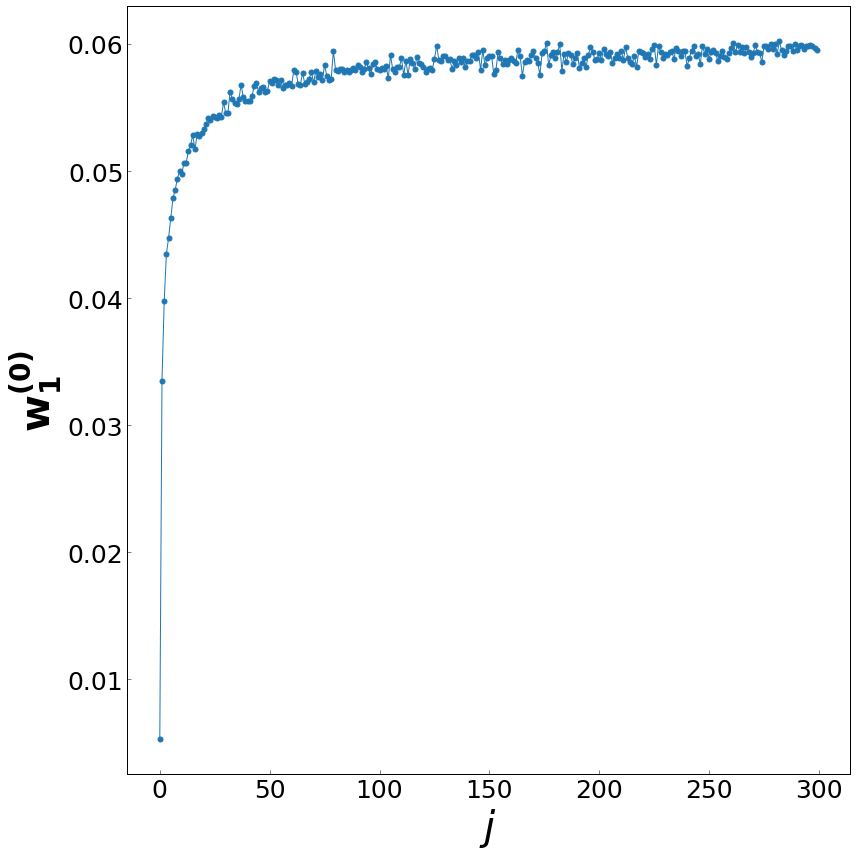

In [18]:
#plot the principal components
#colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1):
    p_data = components[i]
    #plt.plot(range(len(p_data)), p_data, marker='o', linewidth = 1.0, markersize=5, color = colors[i])
    plt.plot(range(len(p_data)), p_data, marker='o', linewidth = 1.0, markersize=5)
    #p_data = components_ig[i]
    #plt.plot(range(len(p_data)), p_data, marker='^', linewidth = 1.0, markersize=5, color = colors[i])  
  

#backround grid details
axes = plt.gca()
#axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
#axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [12,12]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


#axis range and labels (also specify if log or not)
#plt.xlim(0.1,100)

#plt.yscale('log')
plt.xlabel(r'$j$', y=3, fontsize=40, fontdict = axis_label_font)
plt.ylabel(r'$\mathbf{w^{(0)}_1}$', fontsize=40, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=25)
#plt.title('PCA feature weights', y=1.05, fontdict = title_font)

#save figure
fig=plt.figure(1)
plt.tight_layout()
#plt.savefig('figures/OP_orientation_batch_kappa_4_weights.svg',dpi=fig.dpi)

plt.show()

### Order parameters

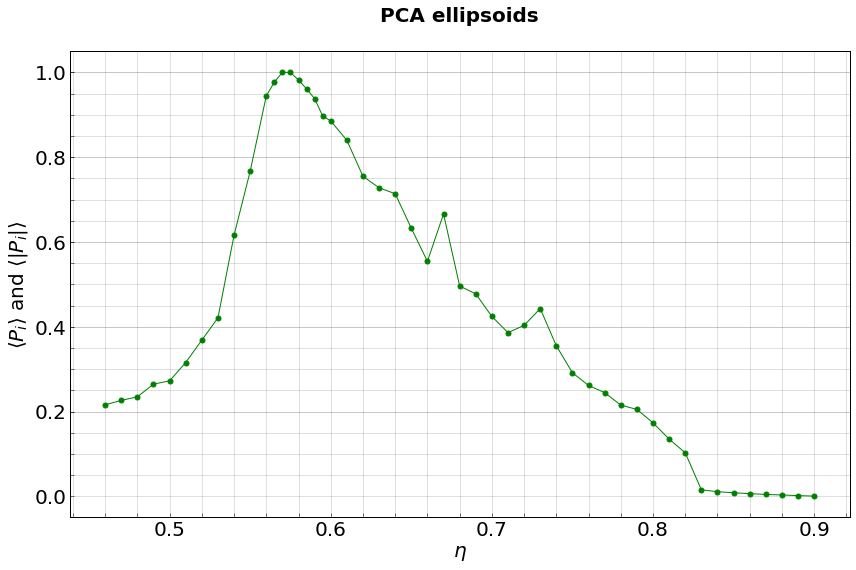

In [20]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1): #12,13
    #p_data = (OPs[:,i]-OPs[0,i])/max(OPs[:,i]-OPs[0,i])
    #p_data = OPs[:,i]
    #plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=10, color = colors[i], markerfacecolor='None')
    p_data = OPs_std[:,i]/max(OPs_std[:,i])
    #plt.plot(etas, (p_data), marker='^', linewidth = 1.0, markersize=12, color = colors[i])
    #p_data = OPs_abs[:,i]
    plt.plot(etas, (p_data), marker='.', linewidth = 1.0, markersize=10, color = colors[i])

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 


#figure size and tick style
plt.rcParams["figure.figsize"] = [12,8]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.60, 0.84)

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA ellipsoids', y=1.05, fontdict = title_font)
plt.minorticks_on()

#save figure
fig=plt.figure(1)
plt.tight_layout()
#plt.savefig('figures/OP_orientation_batch_kappa_4_ave_std.svg',dpi=fig.dpi)

plt.show()

### Save OPs

In [21]:
#Append eta ranges
etas2=etas.reshape(etas.shape[0],1)

#etas2=etas[...,None] #wp: works just as fine
OPsave=np.concatenate((etas2,OPs),1)

#save to txt file
np.savetxt('OPs_kappa6_30k_300_3N.dat',OPsave)
np.savetxt('OPs_kappa6_30k_300_std_3N.dat',OPs_std)